In [19]:
import copy
from concurrent.futures import ThreadPoolExecutor
import random
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import cdlib

In [20]:
class UnionFind:
    def __init__(self, size):
        self.parent = list(range(size))

    def find(self, node):
        if self.parent[node] != node:
            self.parent[node] = self.find(self.parent[node])  # Path compression
        return self.parent[node]

    def union(self, node1, node2):
        root1 = self.find(node1)
        root2 = self.find(node2)
        if root1 != root2:
            self.parent[root2] = root1  # Union

In [74]:
class EstrategiaEvolutiva():
        
    def __init__(self, graph, N=100, init=1, pcross=0.7, pmut=0.01, n_iter=1000, elitism=0):
        self.graph = graph # Grafo
        self.N = N # Tamaño de la población
        self.pop = [] # Población
        self.init = init # Ponderación de la inicialización
        self.pcross = pcross # Probabilidad de cruce
        self.pmut = pmut # Probabilidad de mutación
        self.n_iter = n_iter # Numero de iteraciones
        self.elitism = elitism # Número de individuos que pasan directamente a la siguiente generación
	
    def random_init(self) -> list[int]:
        """ Inicializa individuo de forma aleatoria """

        graph_label = [-1] * len(self.graph.nodes())
        for node in list(self.graph.nodes()):
            neighbors = list(self.graph.neighbors(node))
            if len(neighbors) == 0:
                graph_label[node] = node
            else:
                graph_label[node] = random.choice(neighbors)

        return graph_label

    def label_propagation_init(self) -> list[int]:
        """ Inicializa un individuo mediante el algoritmo de propagación de etiquetas """

        # Se obtienen las comunidades mediante el algoritmo de propagación de etiquetas
        community_dict_values = nx.algorithms.community.asyn_lpa_communities(self.graph)

        # Se crea un mapping de nodos a comunidades
        node_community_map = {}
        for community_id, nodes in enumerate(community_dict_values):
            for node in nodes:
                node_community_map[node] = community_id

        locus_representation = [-1] * len(self.graph.nodes()) 
        
        # Para cada nodo se asigna un nodo vecino de la misma comunidad
        for node in self.graph.nodes():
            community = node_community_map[node] 
            same_community_neighbors = [neighbor for neighbor in self.graph.neighbors(node) if node_community_map[neighbor] == community]
            if same_community_neighbors:
                locus_representation[node] = random.choice(same_community_neighbors)
            else:
                locus_representation[node] = node

        return locus_representation

    def create_pop(self):
        """ Crea una población de N individuos codificados en modo locus """
        
        # Se inicializa la población con individuos aleatorios
        for _ in range(self.N*self.init):
            self.pop.append(self.random_init()) 
        # Se inicializa el resto de la población mediante el algoritmo de propagación de etiquetas
        for _ in range(self.N*(1-self.init)):
            self.pop.append(self.label_propagation_init())

    def decode(self, locus_representation: list[int]) -> dict[int, int]:
        """ Decodifica un individuo en modo locus a modo cluster """
        uf = UnionFind(len(locus_representation))

        for node, neighbor in enumerate(locus_representation):
            uf.union(node, neighbor)

        # Agrupar nodos por su raíz en la estructura Union-Find
        communities = {}
        for node in range(len(locus_representation)):
            root = uf.find(node)
            if root not in communities:
                communities[root] = []
            communities[root].append(node)

        communities = list(communities.values())

        return communities
    
    def plot(self, node_community_map: list[list[int]]):
        """ Pinta el grafo con un color por comunidad """
        #! ARREGLAR PLOT
        # Se obtiene la lista de colores
        node_color_map = {}
        for idx, community in enumerate(node_community_map):
            for node in community:
                node_color_map[node] = idx

        color_map = []
        for node in self.graph.nodes():
            color_map.append(node_color_map[node])

        plt.figure(figsize=(30, 25))
        nx.draw(self.graph, node_color=color_map, with_labels=True)      
        plt.show()
    
    def fitness(self, individual: list[int]) -> float:
        """ Calcula el fitness de un individuo (menor es mejor)
        
        Maximum out degree fraction (ODF): 5
        Average-ODF: 6
        Q: 8
        Community score: 10
        Internal density: 11

        {10, 11}
        {8, 11}
        {6, 10}
        {5, 10}

        """
        communities = self.decode(individual)

        NodeClustering = cdlib.NodeClustering(communities, self.graph)
        NodeClusteringCommunities = [cdlib.NodeClustering([community], self.graph) for community in communities]
        
        avg_odf = sum(cdlib.evaluation.avg_odf(self.graph, community).score for community in NodeClusteringCommunities)
        max_odf = sum(cdlib.evaluation.max_odf(self.graph, community).score for community in NodeClusteringCommunities)
        q = cdlib.evaluation.newman_girvan_modularity(self.graph, NodeClustering).score
        internal_density = sum(1 - cdlib.evaluation.internal_edge_density(self.graph, community).score for community in NodeClusteringCommunities)

        return avg_odf, max_odf, q, internal_density

    def sort_pop(self):
        """ Ordena la población por fitness (de menor a mayor) """
        pass
    
    def tournament_selection(self):
        """ Selección de padres por torneo """
        pass
    
    def single_point_crossover(self):
        """ Crossover de un punto """
        pass

    def multiple_point_crossover(self):
        """ Crossover de k puntos """
        pass

    def uniform_crossover(self):
        """ Crossover uniforme """
        pass
    
    def crossover(self):
        """ Cruce de dos individuos """
        pass

    def mutation(self, individual: list) -> list[int]:
        """ Mutación de un individuo """
        size = len(individual)
        # Se muta cada nodo con probabilidad pmut cambiando el vecino por uno aleatorio
        for i in range(size):
            if random.random() < self.pmut:
                neighbors = self.graph.neighborhood(vertices=i)
                individual[i] = random.choice(neighbors)

        return individual

    def evolve(self):
        """ Evoluciona la población durante n_iter iteraciones """
        pass

            


In [2]:
"""
import networkx as nx

# Crear un grafo con 15 nodos y 23 conexiones
graph = nx.gnm_random_graph(13, 16)
"""

'\nimport networkx as nx\n\n# Crear un grafo con 15 nodos y 23 conexiones\ngraph = nx.gnm_random_graph(13, 16)\n'

In [54]:
# Carga del grafo
graph = nx.read_graphml("data/amazon_graph.graphml")

# Renombramos los nodos al rango [0, N]
mapping = {node: i for i, node in enumerate(graph.nodes())}
graph = nx.relabel_nodes(graph, mapping)


### Plot con inicialización de individuo

In [75]:
es = EstrategiaEvolutiva(graph, N=100, pcross=0.7, pmut=0.01, n_iter=1000, elitism=0)
lb = es.label_propagation_init()
#lb = es.random_init()
communities = es.decode(lb)
es.plot(communities)
print(communities)
a, b, c, d = es.fitness(lb)

TypeError: '_AxesStack' object is not callable

<Figure size 3000x2500 with 0 Axes>

### Plot con ground truth

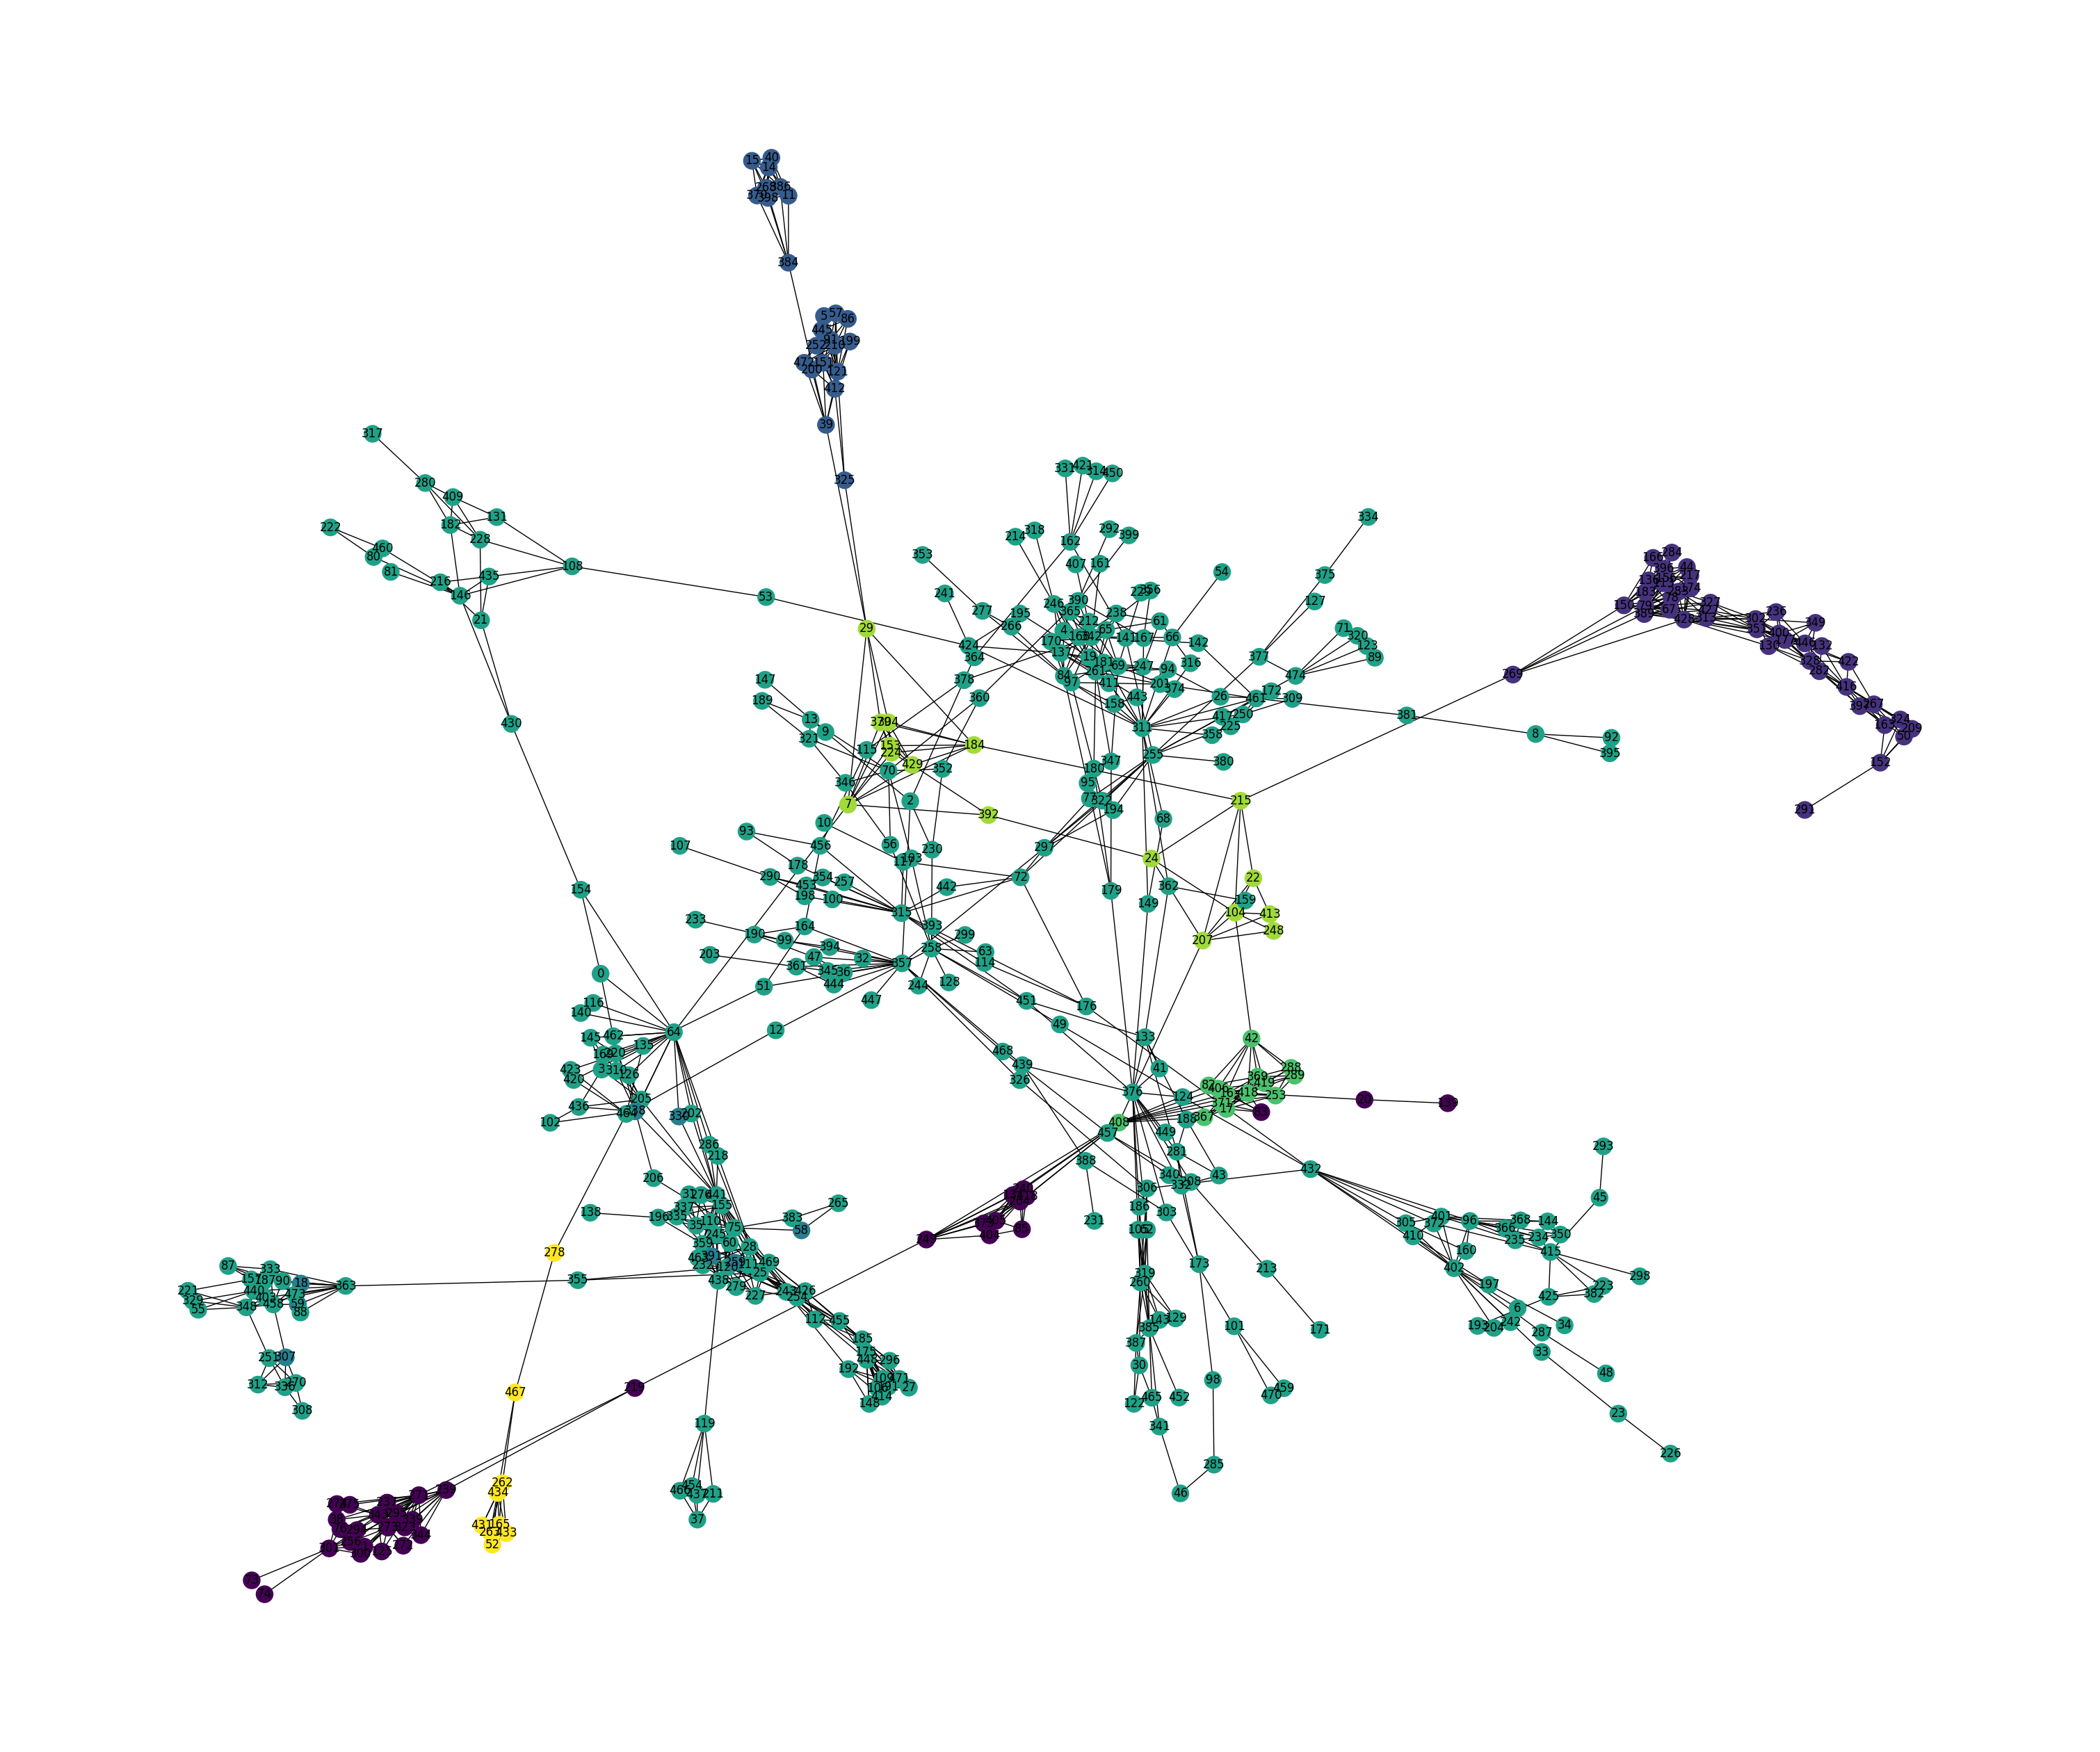

In [123]:
plt.figure(figsize=(30, 25))
nx.draw(graph, node_color=[data['community'] for _, data in graph.nodes(data=True)], with_labels=True)
plt.show()